# Feynman Path Integral for Harmonic Oscillator.
## Formulation
The Feynman path integral serves as an alternative formulation of quantum mechanics.
Although I find it quite beautiful, the mathematical machinery can be quite cumbersome. This nature of the formalism has led it to often manifest as a nightmare in grad students world-wide. In this notebook, I use the formalism to find the ground state energy and wavefunction of the quantum harmonic oscillator by means of numerical techniques. In the future, I naively hope to extend this towards the solution of the Hydrogen atom. As for the formalism itself, it is heavily dependent on the mathematically quantity known as the propagator:
$$K(x_bt_b|x_at_a) = \int_{x_a}^{x_b}D[x(t)]\,\exp\left(\frac{i}{\hbar}S[x(t)]\right)$$
In the exponential of the propagator, one can find the classical action:
$$A[x(t)] = \int_{t_a}^{t_b}dt \, \left(\frac{m\dot{x}^2}{2} - V(x)\right)$$

In [1]:
# python imports
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
#plt.rcParams['text.usetex'] = True

# constants and needed vars
x_a = 0.0
dt = 0.05
m = 0.5
N = 100
num_paths = 5000
bins = 100

Since we know the desired system, let us discretize the action:
$$A[x_n] \approx \Delta t\sum^N_{n=1}\left(\frac{m}{2}\left[\left(\frac{x_n-x_{n-1}}{t_n-t_{n-1}}\right)^2 -x_n^2\right]\right),$$
where $t_n-t_{n-1} \equiv \Delta t$. I also take $\omega=\hbar=1$ for simplicity's sake.

In [2]:
def action(x: np.array) -> float:
    S = 0
    for n in range(N):
        S += dt*0.5*(m*(x[n+1]-x[n])*(x[n+1]-x[n])/dt - m*x[n]*x[n])
    return S  

We must define a fuction that allows for random paths to be generated:

In [3]:
def random_walk(x_a, x_b):
    path = np.zeros(N+1)
    path[0] = x_a
    path[-1] = x_b
    for n in range(1, N):
        path[n] = path[n-1] + np.random.normal(0, np.sqrt(dt))
    return path

We can now sum over a set number of random paths:

In [4]:
def path_integral(x_a, x_b, num_paths):
    total_amplitude = 0.0
    for _ in range(num_paths):
        S = action(random_walk(x_a, x_b))
        amplitude = np.exp(-1j * S)
        total_amplitude += amplitude
    return total_amplitude / num_paths

Using the indentity:
$$\psi(x_b,t_b) = \int_{-\infty}^{\infty}dx_a \, K(x_bt_b|x_at_a)\psi(x_a,t_b)$$
We can solve for our wavefunction:

In [5]:
x = np.linspace(-5.0, 5.0, bins)
psi_n = np.zeros_like(x, dtype=complex)

# numerically solve wavefunction and normalize
for i, x_b in enumerate(x):
    psi_n[i] = path_integral(x_a, x_b, num_paths)
int_psi_sq = scipy.integrate.simpson(abs(psi_n)**2,x=x)
psi_n /= np.sqrt(int_psi_sq)

# define analytical solution
def psi_a_sq(x):
     return np.sqrt(1/(2*math.pi))*np.exp(-0.5*x*x)

We can now compare our result with what theory predicts!

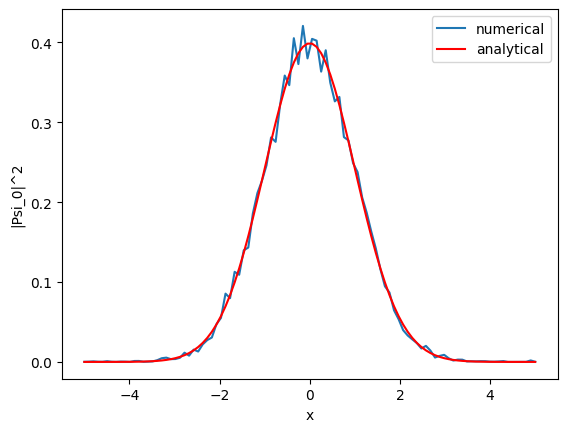

In [6]:
# Plot the wavefunction
plt.plot(x, np.abs(psi_n)**2, label='numerical')
plt.plot(x, psi_a_sq(x), color='red', label='analytical')
plt.xlabel('x')
plt.ylabel('|Psi_0|^2')
plt.legend(loc='best')
plt.show()

It's not the most enlightening value, but let's take the average percent error across the function:

In [7]:
err = 0
for i in range(len(x)):
    numerical = np.abs(psi_n[i])**2
    analytical = psi_a_sq(x[i])
    err += np.abs(numerical - analytical)
print(f'avg percent error: {100*err/len(x)}')

avg percent error: 0.47274839098916965


Let's calculate some expectation values:

In [8]:
def ex_val(var):
    return scipy.integrate.simpson(np.conj(psi_n)*var*psi_n, x=x)

print(f'<x> = {format(ex_val(x), "f")}, expected <x> = 0')
print(f'<x^2> = {format(ex_val(x**2), "f")}, expected <x^2> = 1')
print(f'<x^3> = {format(ex_val(x**3), "f")}, expected <x^3> = 0')
print(f'<x^4> = {format(ex_val(x**4), "f")}, expected <x^4> = 3')

<x> = -0.001930-0.000000j, expected <x> = 0
<x^2> = 1.029117-0.000000j, expected <x^2> = 1
<x^3> = 0.016522-0.000000j, expected <x^3> = 0
<x^4> = 3.492595+0.000000j, expected <x^4> = 3


It's notable that expectation values of higher order requires finer discretization of the system or a higher number of paths generated. Calculating the energy using the virial theorem is now trivial:

In [9]:
print(f'E_0 = <psi_0|x^2|psi_0> = {format(0.5*ex_val(x**2),"f")} , expected E_0 = 0.5')

E_0 = <psi_0|x^2|psi_0> = 0.514558-0.000000j , expected E_0 = 0.5
